# Longitudinal Vehicle Model Representation of a Car

The Longitudinal Vehicle model is based on the simple dynamics of the vehicle that make the vehicle move forward.

The equations defining the vehicles motion are described below : 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
        
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

Here, we design a function step that changes the values of the state variables according to the given inputs of throttle (i.e. throttle percentage) and alpha (i.e. incline angle of the surface). This function is designed assuming that each step is taken at an interval of time that is very very small. This helps us we can imply by this that change in various variables during that time interval is negligible.

In [6]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        
        # Calculating w_w
        w_w = self.GR * self.w_e
        # Calculating s
        s = (w_w * self.r_e / self.v) - 1
        # Claculating F_x
        F_x = self.F_max
        if s<1 and s>-1 :
            F_x = self.c * s
        # Calculating F_aero
        F_aero = self.c_a * (self.v ** 2)
        # Calculating R_x
        R_x = self.c_r1 * self.v
        # Calculating F_g
        F_g = self.m * self.g * np.sin(alpha)
        # Calculating F_load
        F_load = F_aero + R_x + F_g
        # Setting a
        self.a = (F_x - F_load) / self.m
        # Setting v
        self.v = self.a * self.sample_time + self.v
        # Setting x
        self.x = self.v * self.sample_time + self.x
        # Calculating T_e
        T_e = throttle * (self.a_0 + (self.a_1 * self.w_e) + (self.a_2 * (self.w_e ** 2)))
        # Setting w_e_dot
        self.w_e_dot = (T_e -(self.GR * self.r_e * F_load))/self.J_e
        # Setting w_e
        self.w_e = self.w_e_dot * self.sample_time + self.w_e
        
        pass

In the next cell we try to drive the vehicle over the slope shown in the diagram below. 

![ramp](ramp.png)

To climb the slope, a trapezoidal throttle input is provided for the next 20 seconds as shown in the figure below. 

![throttle](throttle.png)

The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

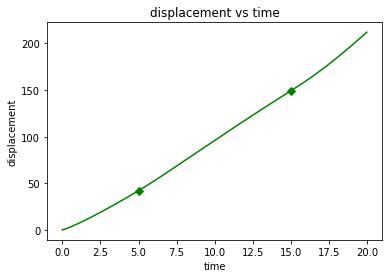

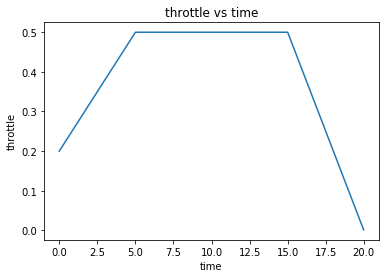

In [21]:
sample_time = 0.01
time_end = 20
model = Vehicle()
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
a_data = np.zeros_like(t_data)
throttle_data = np.zeros_like(t_data)

# reset the states
model.reset()

def throttle(t) : 
    if t<500 :
        throttle_data[t] = (0.2 + 0.0006 * t)
        return (0.2 + 0.0006 * t)
    elif t<1500 :
        throttle_data[t] = 0.5
        return 0.5
    else :
        throttle_data[t] = (0.5 - 0.001 * (t-1500))
        return (0.5 - 0.001 * (t-1500))

def alpha(x) : 
    if x<60 :
        return np.arctan(3/60)
    elif x<150 :
        return np.arctan(9/90)
    else :
        return 0
    
for i in range(t_data.shape[0]):
    x_data[i] = model.x
    model.step(throttle(i), alpha(model.x))

# Plot x vs t for visualization
plt.title("displacement vs time")
plt.xlabel('time')
plt.ylabel('displacement')
markers_on = [500, 1500]
plt.plot(t_data, x_data, '-gD', markevery=markers_on)
plt.show()

# Plot throttle vs t for visualization
plt.title("throttle vs time")
plt.xlabel('time')
plt.ylabel('throttle')
plt.plot(t_data, throttle_data)
plt.show()

Here, we can see the throttle vs time graph is identical to the case. And by looking at the displacement graph we can see that the slope is traversed according to the statement. We can also see when the car actually changes it's throttle value according to it's position on the slope.